# Загрузка данных
Нужно подключиться к гугл диску на котором лежат файлы.

Папка gaze для файлов 'User 0_all_gaze.csv'

Папка info для файлов 'subject-0.csv'

Папка images для изображений

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
folder_name = 'NN for emotions' # имя папки с .csv данными на гугл диске
path = 'drive/MyDrive/' + folder_name # так будет выглядеть путь до папки на гугл диске из колаба

# Обработка

In [3]:
#@title Imports, model loading, helping functions
import os
import pandas as pd
import numpy as np
import cv2
from scipy.signal import sosfiltfilt, butter, detrend
import matplotlib.pyplot as plt
from keras.models import load_model
from tensorflow.keras import utils
from datetime import datetime
import time

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

arousal = load_model(path+'/arousal.h5')
valence = load_model(path+'/valence.h5')


fs = 61 # Hz
f_type = 'bandpass' # highpass lowpass
f_order = 4
f1 = 0.1 # Hz
f2 = 3 # Hz

low = f1 / (fs / 2)
high = f2 / (fs / 2)
sos = butter(f_order, [low, high], btype=f_type, output='sos') # [low, high]

def analyze_gaze(gaze_path, info_path):

  gaze = pd.read_csv(gaze_path)
  info = pd.read_csv(info_path, sep=None, engine='python') #, delimiter=';')

  gaze_time_col = [i for i in gaze.columns.values if i[:5] == 'TIME('][0]
  gaze_start = datetime.strptime(gaze_time_col[5:-1], '%Y/%m/%d %H:%M:%S.%f')
  img_start = datetime.strptime(info.start_time_system[0], '%d/%m/%y %H:%M:%S.%f')
  print(gaze_path, gaze_start)
  print(info_path, img_start)

  if abs((img_start.timestamp() - gaze_start.timestamp()) * 1000) > 1000000:
    print("FILES HAVE BIG TIME DIFFERENCE")
    print()
    return [], [], [], []

  fs = gaze.CNT.iloc[-1] / gaze[gaze_time_col].iloc[-1]
  counter = np.array(info.time_Images[1::2] - ((img_start.timestamp() - gaze_start.timestamp()) * 1000)) / 1000 * fs
  counter = counter.astype(int)

  images = list(info.Image[1::2])
  arousal = np.array(info.form_response[1::2]).astype(int)
  valence = np.array(info.form_response[2::2]).astype(int)

  gaze.loc[gaze.FPOGV == 0, ['FPOGX', 'FPOGY']] = np.nan
  gaze.loc[gaze.LPMMV == 0, ['LPMM']] = np.nan
  gaze.loc[gaze.RPMMV == 0, ['RPMM']] = np.nan
  gaze.loc[gaze.GSRV == 0, ['GSR']] = np.nan
  gaze.loc[gaze.HRV == 0, ['HR']] = 80

  to_interpolate = ['FPOGX', 'FPOGY', 'LPMM', 'RPMM', 'GSR', 'HR']
  gaze[to_interpolate] = gaze[to_interpolate].interpolate(method='linear', axis=0)

  new_col = np.zeros(len(gaze))
  new_col[counter] = 1
  gaze['ep_begin'] = new_col

  data = gaze

  data['mean_PMM'] = (data.LPMM + data.RPMM)/2
  data.mean_PMM = data.mean_PMM.rolling(window=10, min_periods=0, center=True).mean()
  data.GSR = data.GSR.rolling(window=100, min_periods=0, center=True).mean()
  data.GSR = sosfiltfilt(sos, data.GSR)
  data.HR = data.HR.rolling(window=100, min_periods=0, center=True).mean()

  idx = np.where(data.ep_begin == 1)[0] # начало эпох
  ns = len(idx) # число показанных картинок
  t_range = 300 # длина эпохи
  vars_ = ['FPOGX', 'FPOGY', 'mean_PMM', 'GSR', 'HR']

  time_series = np.zeros((ns, t_range, len(vars_)))
  imnames = images
  ar_val = np.zeros((ns, 2))
  ar_val[:, 0] = arousal
  ar_val[:, 1] = valence

  for n, i in enumerate(idx[1:-1]):
      time_series[n] = np.array(data[vars_][i:(i+t_range)])

  print('nans:', np.isnan(time_series).sum())

  im_size = 190
  scanpaths = np.zeros((ns, im_size, im_size))
  for n, i1 in enumerate(idx[1:-1]):
      i2 = i1+t_range

      img_ = np.zeros((im_size, im_size), dtype=np.uint8)
      x0, y0 = data.FPOGX[i1], data.FPOGY[i1]
      for i in range(i1, i2):
          if (data.FPOGID[i] != data.FPOGID[i+1]) and (np.isnan(data.FPOGID[i]) != True):

              x1, y1 = int(x0*im_size), int(y0*im_size)
              x2, y2 = int(data.FPOGX[i]*im_size), int(data.FPOGY[i]*im_size)

              cv2.line(img_, [x1, y1], [x2, y2], 255, 1)

              overlay = img_.copy()
              radius = int(data.FPOGD[i]*10)
              cv2.circle(overlay, [x2, y2], radius, 255, -1)
              alpha = 0.5
              img_ = cv2.addWeighted(overlay, alpha, img_, 1 - alpha, 0)

              x0, y0 = data.FPOGX[i], data.FPOGY[i]


      x1, y1 = int(x0*im_size), int(y0*im_size)
      x2, y2 = int(data.FPOGX[i2-1]*im_size), int(data.FPOGY[i2-1]*im_size)

      cv2.line(img_, [x1, y1], [x2, y2], 255, 1)

      scanpaths[n] = img_

  print()

  return scanpaths, time_series, imnames, ar_val

def normalize_data(all_scanpaths, all_time_series, images, for_):

  for i in range(len(all_time_series)):
      all_time_series[i][:, :, 3] = (all_time_series[i][:, :, 3] - all_time_series[i][:, :, 3].mean()) / all_time_series[i][:, :, 3].std()
      all_time_series[i][:, :, 4] = (all_time_series[i][:, :, 4] - all_time_series[i][:, :, 4].mean()) / all_time_series[i][:, :, 4].std()

  if len(all_time_series) > 1:
    all_time_series = np.concatenate(all_time_series, axis=0)
    all_scanpaths = np.concatenate(all_scanpaths, axis=0)
  else:
    all_time_series = np.array(all_time_series)
    all_scanpaths = np.array(all_scanpaths)

  good_idx = [i for i, img in enumerate(images) if (img.size > 0)]

  all_scanpaths = all_scanpaths[good_idx]
  all_time_series = all_time_series[good_idx]
  images = [images[i] for i in good_idx]
  images = np.array(images)
  print('scanpaths shape:', all_scanpaths.shape)
  print('time epochs shape:', all_time_series.shape)
  print('images shape:', images.shape)

  if for_ == 'arousal':
    mean_eyetrack_im, std_eyetrack_im = 7.131651555358986, 36.16908424287419
    all_scanpaths = (all_scanpaths - mean_eyetrack_im) / std_eyetrack_im
    mean_pics, std_pics = 112.8596743479614, 73.17328261021949
    images = (images - mean_pics) / std_pics
    mean_time = [0.47930163769475365, 0.5025483869187797, 3.1917097768767384, 0.00028441952899300294, -0.028459507535657676]
    std_time =[0.13809510924886878, 0.18233709273559534, 0.5665284210514095, 0.9589779244665103, 0.900008415925623]
    for i, mean, std in zip(range(5), mean_time, std_time):
      all_time_series[:, :, i] = (all_time_series[:, :, i] - mean)/std

  elif for_ == 'valence':
    mean_eyetrack_im, std_eyetrack_im = 7.221206373518936, 36.36375114631994
    all_scanpaths = (all_scanpaths - mean_eyetrack_im) / std_eyetrack_im
    mean_pics, std_pics = 112.58524645266107, 72.8678856743275
    images = (images - mean_pics) / std_pics
    mean_time = [0.474979143899135, 0.5084496562556537, 3.1761275344961803, -0.00626148824116919, -0.011207830193312656]
    std_time = [0.14301775240641512, 0.1960988680713403, 0.5843657264344913, 1.0180995129880201, 0.948138649624869]
    for i, mean, std in zip(range(5), mean_time, std_time):
      all_time_series[:, :, i] = (all_time_series[:, :, i] - mean)/std

  return all_scanpaths[:, :, :, None], all_time_series[:, None, :, :], images


def load_img(imnames, path=path):
  images = []
  good_imnames = []
  for i in imnames:
    try:
      img = utils.load_img(path+'/'+i, target_size=(200, 250), color_mode='rgb')
      img = utils.img_to_array(img)
      good_imnames.append(i)
      images.append(img)
    except:
      images.append(np.array([]))

  return images, good_imnames

def get_data(gaze_paths, info_paths, for_='arousal', path=path):

  all_scanpaths = []
  all_time_series = []
  all_imnames = []
  all_ar_val = []

  for gaze_path, info_path in zip(gaze_paths, info_paths):
    scanpaths, time_series, imnames, ar_val = analyze_gaze(gaze_path, info_path)
    if len(scanpaths) != 0:
      all_scanpaths.append(scanpaths)
      all_time_series.append(time_series)
      all_imnames.append(imnames)
      all_ar_val.append(ar_val)

  all_ar_val = np.concatenate(all_ar_val)

  all_imnames_conc = list(np.concatenate(all_imnames))
  images, good_imnames = load_img(all_imnames_conc, path)

  good_idx = [i for i, img in enumerate(images) if (img.size > 0)]
  all_ar_val = all_ar_val[good_idx]

  all_scanpaths_norm, all_time_series_norm, images_norm = normalize_data(all_scanpaths, all_time_series, images, for_=for_)

  return all_scanpaths_norm, all_time_series_norm, images_norm, all_ar_val, good_imnames

In [ ]:
#@title Confusion matrix
def confusion(true, predicted):
  # true -= 1
  # predicted = np.argmax(predicted, axis=-1)
  cm = confusion_matrix(true, predicted, normalize='true')

  CLASS_LIST = np.arange(1, 8)
  # Отрисовка матрицы ошибок
  fig, ax = plt.subplots(figsize=(3, 3))
  ax.set_title(f'матрица ошибок', fontsize=12)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_LIST)
  disp.plot(ax=ax)
  plt.gca().images[-1].colorbar.remove()  # Стирание ненужной цветовой шкалы
  plt.xlabel('Предсказанные классы', fontsize=10)
  plt.ylabel('Верные классы', fontsize=10)
  plt.grid(False)
  plt.show()

## Перечисление имён файлов

In [ ]:
files = os.listdir(path+'/gaze')
files = sorted(files, key=lambda i:int(i.split(' ')[1].split('_')[0]))
gaze_paths = [path+'/gaze/'+i for i in files]
gaze_paths

['drive/MyDrive/NN for emotions/gaze/User 16_all_gaze.csv',
 'drive/MyDrive/NN for emotions/gaze/User 17_all_gaze.csv',
 'drive/MyDrive/NN for emotions/gaze/User 18_all_gaze.csv',
 'drive/MyDrive/NN for emotions/gaze/User 19_all_gaze.csv',
 'drive/MyDrive/NN for emotions/gaze/User 20_all_gaze.csv',
 'drive/MyDrive/NN for emotions/gaze/User 21_all_gaze.csv',
 'drive/MyDrive/NN for emotions/gaze/User 22_all_gaze.csv',
 'drive/MyDrive/NN for emotions/gaze/User 23_all_gaze.csv']

In [ ]:
files = os.listdir(path+'/info')
files = sorted(files, key=lambda i:int(i.split('-')[1].split('.')[0]))
info_paths = [path+'/info/'+i for i in files]
info_paths

['drive/MyDrive/NN for emotions/info/subject-16.csv',
 'drive/MyDrive/NN for emotions/info/subject-17.csv',
 'drive/MyDrive/NN for emotions/info/subject-18.csv',
 'drive/MyDrive/NN for emotions/info/subject-19.csv',
 'drive/MyDrive/NN for emotions/info/subject-20.csv',
 'drive/MyDrive/NN for emotions/info/subject-21.csv',
 'drive/MyDrive/NN for emotions/info/subject-22.csv',
 'drive/MyDrive/NN for emotions/info/subject-23.csv']

In [ ]:
scanpaths, time_series, images, y, good_imnames = get_data(gaze_paths, info_paths, for_='arousal', path=path)
arousal_predicted = arousal.predict([scanpaths, time_series, images]).argmax(-1) + 1

drive/MyDrive/NN for emotions/gaze/User 16_all_gaze.csv 2023-06-23 12:29:51.502000
drive/MyDrive/NN for emotions/info/subject-16.csv 2023-06-23 12:30:11.518103
nans: 12000

drive/MyDrive/NN for emotions/gaze/User 17_all_gaze.csv 2023-06-23 15:30:41.868000
drive/MyDrive/NN for emotions/info/subject-17.csv 2023-06-23 15:31:07.247433
nans: 0

drive/MyDrive/NN for emotions/gaze/User 18_all_gaze.csv 2023-06-23 16:07:05.479000
drive/MyDrive/NN for emotions/info/subject-18.csv 2023-06-23 16:07:27.003825
nans: 0

drive/MyDrive/NN for emotions/gaze/User 19_all_gaze.csv 2023-06-23 16:50:27.562000
drive/MyDrive/NN for emotions/info/subject-19.csv 2023-06-23 16:50:47.093190
nans: 0

drive/MyDrive/NN for emotions/gaze/User 20_all_gaze.csv 2023-06-24 11:42:28.202000
drive/MyDrive/NN for emotions/info/subject-20.csv 2023-06-24 11:42:57.735987
nans: 0

drive/MyDrive/NN for emotions/gaze/User 21_all_gaze.csv 2023-06-24 12:36:26.669000
drive/MyDrive/NN for emotions/info/subject-21.csv 2023-06-24 12:36:4

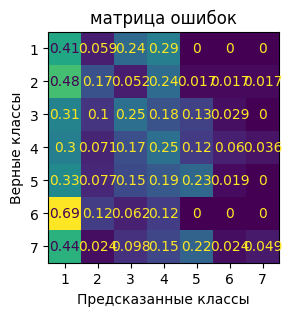

0.20535714285714285

In [ ]:
confusion(y[:, 0], arousal_predicted)
(y[:, 0] == arousal_predicted).sum() / len(arousal_predicted)

In [ ]:
scanpaths, time_series, images, y, good_imnames = get_data(gaze_paths, info_paths, for_='valence', path=path)
valence_predicted = valence.predict([scanpaths, time_series, images]).argmax(-1) + 1

drive/MyDrive/NN for emotions/gaze/User 16_all_gaze.csv 2023-06-23 12:29:51.502000
drive/MyDrive/NN for emotions/info/subject-16.csv 2023-06-23 12:30:11.518103
nans: 12000

drive/MyDrive/NN for emotions/gaze/User 17_all_gaze.csv 2023-06-23 15:30:41.868000
drive/MyDrive/NN for emotions/info/subject-17.csv 2023-06-23 15:31:07.247433
nans: 0

drive/MyDrive/NN for emotions/gaze/User 18_all_gaze.csv 2023-06-23 16:07:05.479000
drive/MyDrive/NN for emotions/info/subject-18.csv 2023-06-23 16:07:27.003825
nans: 0

drive/MyDrive/NN for emotions/gaze/User 19_all_gaze.csv 2023-06-23 16:50:27.562000
drive/MyDrive/NN for emotions/info/subject-19.csv 2023-06-23 16:50:47.093190
nans: 0

drive/MyDrive/NN for emotions/gaze/User 20_all_gaze.csv 2023-06-24 11:42:28.202000
drive/MyDrive/NN for emotions/info/subject-20.csv 2023-06-24 11:42:57.735987
nans: 0

drive/MyDrive/NN for emotions/gaze/User 21_all_gaze.csv 2023-06-24 12:36:26.669000
drive/MyDrive/NN for emotions/info/subject-21.csv 2023-06-24 12:36:4

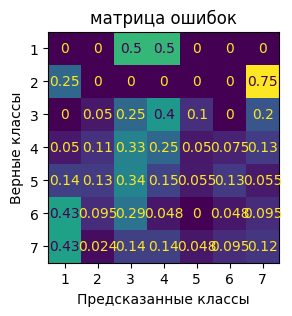

0.14285714285714285

In [ ]:
confusion(y[:, 1], valence_predicted)
(y[:, 1] == valence_predicted).sum() / len(valence_predicted)

In [ ]:
df = {
    'picture_name':good_imnames,
    'arousal_level_predicted':arousal_predicted,
    'arousal_level_true':list(y[:, 0]),
    'valence_level_predicted':valence_predicted,
    'valence_level_true':list(y[:, 1])
    }
df = pd.DataFrame(df)
df.head()

,picture_name,arousal_level_predicted,arousal_level_true,valence_level_predicted,valence_level_true
0,Images/8.jpg,1,4.0,1,5.0
1,Images/16.jpg,1,5.0,1,7.0
2,Images/12.jpg,1,7.0,1,7.0
3,Images/5.jpg,1,4.0,1,5.0
4,Images/6.jpg,1,4.0,1,5.0


In [ ]:
df

,picture_name,arousal_level_predicted,arousal_level_true,valence_level_predicted,valence_level_true
0,Images/8.jpg,1,4.0,1,5.0
1,Images/16.jpg,1,5.0,1,7.0
2,Images/12.jpg,1,7.0,1,7.0
3,Images/5.jpg,1,4.0,1,5.0
4,Images/6.jpg,1,4.0,1,5.0
...,...,...,...,...,...
331,Images/20.jpg,4,4.0,2,4.0
332,Images/n12.jpg,3,5.0,5,5.0
333,Images/17.jpg,4,5.0,3,5.0
334,Images/q5.jpg,1,4.0,6,5.0


In [ ]:
aggregated = df.groupby('picture_name').aggregate('mean')
aggregated.to_csv(path+'/results/mean_res.csv')
aggregated.head()

,arousal_level_predicted,arousal_level_true,valence_level_predicted,valence_level_true
picture_name,,,,
Images/1.jpg,2.125,4.250,3.125,5.125
Images/10.jpg,1.875,3.750,2.500,4.375
Images/11.jpg,2.625,4.375,2.500,5.375
Images/12.jpg,2.375,4.000,4.000,5.250
Images/13.jpg,2.250,4.500,2.750,5.500


# Analysis visualization

In [ ]:
names = [
    'Images/accident 1.jpg'
]